In [1]:
%matplotlib inline

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow.keras as keras
from tensorflow.keras import layers
# from tensorflow.keras import ops
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

from IPython.display import HTML

from graph_visualization import GraphVisualization

print("Tensorflow verions:", tf.__version__)
print('Available GPUs:', tf.config.experimental.list_physical_devices('GPU'))

Tensorflow verions: 2.4.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_weights(self):
        return [self.att.get_weights(), self.ffn.layers[0].get_weights(), self.ffn.layers[1].get_weights()]

    def set_weights(self, weights):
        self.att.set_weights(weights[0])
        self.ffn.layers[0].set_weights(weights[1])
        self.ffn.layers[1].set_weights(weights[2])

In [415]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 10  # Max sequence size
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "gpt-dataset/custom-2.4"
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

# filenames = filenames[:10000]

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

from sklearn.feature_extraction.text import CountVectorizer
def count_occurences(text_ds):

    def preprocess_text(text):
        # Custom text preprocessing
        # For example, you can perform lowercasing, punctuation removal, etc.
        return text.lower()
    
    # Preprocess the text data and convert it to a list
    preprocessed_texts = [preprocess_text(str(text.numpy())) for text in text_ds]
    # Initialize CountVectorizer
    vectorizer = CountVectorizer()
    # Fit CountVectorizer on preprocessed text data and transform it into token counts
    token_counts = vectorizer.fit_transform(preprocessed_texts)
    # Get the vocabulary and token counts
    vocab = vectorizer.get_feature_names_out()
    counts = token_counts.toarray().sum(axis=0)
    # Create a dictionary to store token counts
    token_counts_dict = dict(zip(vocab, counts))

    token_counts_dict = sorted(token_counts_dict.items(), key=lambda item: item[1], reverse=True)
    
    print(token_counts_dict)

# count_occurences(text_ds)

3 files


In [416]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]

    # zeros_column = tf.zeros_like(y[:, :1])  # Create a column of zeros with the same shape as the first column of y
    # y = tf.concat([zeros_column, y], axis=1)  # Concatenate the zeros column with y along the column axis

    return x, y

text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

def prepare_node_vector_outputs(text_ds, node_embeddings):
    def process(x,y):
        return x, tf.gather(node_embeddings, y)
        
    return text_ds.map(process, num_parallel_calls=tf_data.AUTOTUNE)

graph_ds = prepare_node_vector_outputs(text_ds, final_embeddings)
graph_ds = graph_ds.prefetch(tf_data.AUTOTUNE)

In [417]:
take = list(graph_ds.take(1))

In [447]:
take[0][1].shape, graph_ds, text_ds

(TensorShape([20, 10, 128]),
 <PrefetchDataset shapes: ((None, 10), (None, 10, 128)), types: (tf.int64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 10), (None, 10)), types: (tf.int64, tf.int64)>)

In [398]:
i = take[0][0][0][1].numpy()
i, take[0][0][0], take[0][2][0][0] == final_embeddings[i]
# take[0][1].shape

(6,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 2,  6,  3,  9,  5,  4, 14,  7,  0,  0], dtype=int64)>,
 <tf.Tensor: shape=(128,), dtype=bool, numpy=
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  Tru

In [166]:
sources = ['guitar', 'guitar', 'guitar', 'violin', 'violin', 'violin', 'piano', 'piano', 'piano', 'car', 'car', 'car', 'truck', 'truck', 'truck', 'Neck', 'Strings', 'Keys', 'Pedals', 'Wheels', 'Baggage', 'Trunk']
labels = ['is', 'has', 'has', 'is', 'has', 'has', 'is', 'has', 'has', 'is', 'has', 'has', 'is', 'has', 'has', 'is', 'is', 'is', 'is', 'is', 'is', 'is']
targets = ['instrument', 'neck', 'strings', 'instrument', 'neck', 'strings', 'instrument', 'keys', 'pedals', 'vehicle', 'wheels', 'baggage', 'vehicle', 'wheels', 'trunk', 'part', 'part', 'part', 'part', 'part', 'part', 'part']
graph_data = pd.DataFrame({'source': sources, 'label': labels, 'target': targets})

rel_graphs = {}
for index, row in graph_data.iterrows():
    df = rel_graphs.get(row['label'], pd.DataFrame({'source': [], 'label': [], 'target': []}))
    df = df.append({'source': row['source'], 'label': row['label'], 'target': row['target']}, ignore_index=True)
    rel_graphs[row['label']] = df
    
# rel_graphs['is']

,source,label,target
0,guitar,is,instrument
1,violin,is,instrument
2,piano,is,instrument
3,car,is,vehicle
4,truck,is,vehicle
5,Neck,is,part
6,Strings,is,part
7,Keys,is,part
8,Pedals,is,part
9,Wheels,is,part


In [105]:
graph_embedding_size = 128

def node2vec(G):
        walk_length = 100
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=G.nodes(),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False,  # for weighted random walks
            seed=42,  # random seed fixed for reproducibility
        )

        model = Word2Vec(
            walks,  vector_size=graph_embedding_size, window=5, min_count=0, sg=1, workers=1
        )

        return pd.DataFrame([(key, vector) for key,vector in zip(model.wv.index_to_key, model.wv.vectors)], columns=['node', 'embedding'])

def fill_graph(graph, vocab):
    for word in vocab:
        graph['nodes'].append(word) if word not in graph['nodes'] else None

    return graph
    
def get_graph(graph_data):
    nodes, edges, edge_types = [], [], []

    for word in graph_data['source'].unique():
        nodes.append(word)

    for word in graph_data['target'].unique():
        nodes.append(word) if word not in nodes else None

    for index, row in graph_data.iterrows():
        edges.append({'source': row['source'], 'target': row['target']})
        edge_types.append(row['label'])

    graph = {'nodes':nodes, 'edges': edges, 'edge_types': edge_types}

    graph = fill_graph(graph, vocab)
    
    edges_ = pd.DataFrame({
            'source': [e['source'] for e in graph['edges']],
            'target': [e['target'] for e in graph['edges']],
            'type': graph['edge_types']
        })

    G = StellarGraph(IndexedArray(index=graph['nodes']), edges_, edge_type_column="type")
    
    return graph, G

def get_embeddings(G):
    node_embeddings = complex_embeddings(G, conceptnet_data[['source','label','target']])
        
    return node_embeddings
    
# graph, G = get_graph(graph_data)
# final_embeddings = node2vec(G)

# tmp = []
# for i,word in enumerate(vocab):
#     lower_nodes = list(map(lambda k: k.lower(), final_embeddings['node']))
#     index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
#     if index != -1:
#         tmp.append(final_embeddings.iloc[index][1])
#     else:
#         tmp.append(np.ones(graph_embedding_size) * -10)

# final_embeddings = np.array(tmp)

graphs, node_embeddings = [], []
for key, _graph_data in rel_graphs.items():
    graph, G = get_graph(_graph_data)
    graphs.append(graph)
    node_embeddings.append(node2vec(G))

for j, emb in enumerate(node_embeddings):
    tmp = []
    lower_nodes = list(map(lambda k: k.lower(), emb['node']))
    for i,word in enumerate(vocab):
        index = lower_nodes.index(word.lower()) if word.lower() in lower_nodes else -1
        if index != -1:
            tmp.append(emb.iloc[index][1])
        else:
            tmp.append(np.ones(graph_embedding_size) * -10)
    
    node_embeddings[j] = np.array(tmp).tolist()

node_embeddings = np.array(node_embeddings)

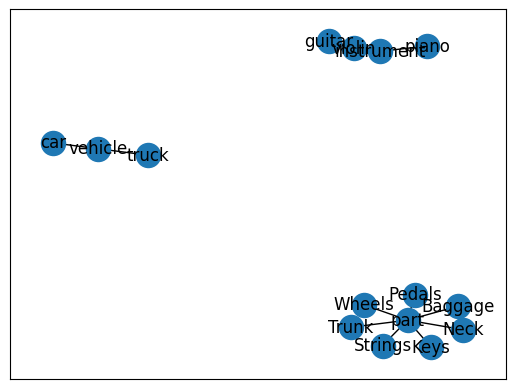

In [32]:
graph = graphs[0]
index = 0
vis = GraphVisualization()
for edge in graph['edges'][index:index+30]:
    vis.addEdge(edge['source'], edge['target'])
vis.visualize()

In [33]:
index_A = vocab.index('instrument')
index_B = vocab.index('neck')
index_C = vocab.index('keys')
index_D = vocab.index('pedals')

from numpy.linalg import norm

def cosine_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

embeddings = node_embeddings[0]
# embeddings = final_embeddings
A,B,C,D = embeddings[index_A], embeddings[index_B], embeddings[index_C], embeddings[index_D]
cosine_sim(A,B), cosine_sim(A,C), cosine_sim(A,D), cosine_sim(B,C), cosine_sim(B,D), cosine_sim(C,D)

(0.7247183894045303,
 0.736921783581227,
 0.7309369659619077,
 0.9983007622252905,
 0.9990524239944755,
 0.9984080746528202)

In [34]:
final_embeddings = None
for i in range(0, node_embeddings.shape[0] - 1):
    embeddings =  np.concatenate((node_embeddings[i], node_embeddings[i + 1]), axis=1)
    final_embeddings = embeddings if not final_embeddings else np.concatenate((final_embeddings, embeddings), axis = 1) 

final_embeddings = node_embeddings[0]
final_embeddings.shape

(24, 128)

In [35]:
# [(word, emb) for word, emb in zip(vocab, final_embeddings)]

In [36]:
class TextGenerator(tf.keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, model = None, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        if model: self.model = model
        self.yes_count = 0
        self.no_count = 0
        self.activation_outputs = []
        self.gradients = []

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = tf.convert_to_tensor(indices, dtype=tf.int32)
        preds = tf.keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = tf.convert_to_tensor(preds, dtype=tf.float32)
  
        # Reshape logits to a matrix
        logits_matrix = tf.reshape(logits, (1, -1))
   
        # Sample from the softmax probabilities
        sampled_index = tf.random.categorical(tf.math.log(preds)[tf.newaxis, :], num_samples=1)

        # Return the sampled index
        return indices[sampled_index[0, 0]]

    def detokenize(self, number):
        return self.index_to_word[number] if number < len(self.index_to_word) else '---'

    def generate_token(self, start_tokens, tokens_generated):
        pad_len = maxlen - len(start_tokens)
        sample_index = len(start_tokens) - 1
        if pad_len < 0:
            x = start_tokens[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            x = start_tokens + [0] * pad_len
        else:
            x = start_tokens
        x = np.array([x])
        y = self.model.predict(x, verbose=0)
        sample_token = self.sample_from(y[0][sample_index])
        tokens_generated.append(sample_token)
        start_tokens.append(sample_token)
        num_tokens_generated = len(tokens_generated)

        return start_tokens, tokens_generated, num_tokens_generated, y

    def get_generated_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in tokens_generated])
        
    def get_text(self, tokens_generated):
        return " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        
    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        raw_outputs = []
        while num_tokens_generated <= self.max_tokens:
            start_tokens, tokens_generated, num_tokens_generated, raw_output = self.generate_token(start_tokens, tokens_generated)
            raw_outputs.append(raw_output)
            
        txt = self.get_text(tokens_generated)
        print(f"generated text:\n{txt}\n")

        self.yes_count += 1 if 'yes' in txt else 0
        self.no_count += 1 if 'no' in txt else 0

        return txt, raw_outputs
    
    def generate(self):
        return self.on_epoc_end(1)

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

def callback(start_prompt, model=None, top_k=10):
    start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
    num_tokens_generated = 10
    return TextGenerator(num_tokens_generated, start_tokens, vocab, top_k=top_k) if not model else TextGenerator(num_tokens_generated, start_tokens, vocab, model, top_k)

In [37]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # Modified line
        positions = tf.range(0, maxlen, 1)  # Modified line
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [38]:
class NodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, node_embeddings, **kwargs):
        super().__init__(**kwargs)
        self.node_embeddings = tf.constant(node_embeddings, dtype=tf.float32)
        self.node_embed_dim = node_embed_dim
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
         # Reshape x to add a new dimension for embedding
        node_indices = tf.cast(tf.math.round(x), tf.int32)
        node_emb = tf.gather(self.node_embeddings, node_indices)
        node_emb = self.dense(node_emb)  # Apply dense layer to each token embedding
        return node_emb

In [463]:
t1 = tf.constant([
    [[1,2,3],[4,5,6]],
    [[7,8,9],[10,11,9]]
])

tf.argmax(t1, axis=-1)

<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[2, 2],
       [2, 1]], dtype=int64)>

In [685]:
class EmbeddingTransformation(layers.Layer):
    def __init__(self, node_embeddings, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.node_embeddings = node_embeddings
        self.normalized_node_embeddings = tf.nn.l2_normalize(tf.constant(node_embeddings, dtype=tf.float32), axis=1)
        self.dense = keras.layers.Dense(vocab_size, trainable=True)

    def call(self, x):
        # tf.print('-----')
        normalized_output_embedding = tf.nn.l2_normalize(x, axis=0)
        
        # Compute cosine similarities
        similarities = tf.matmul(self.normalized_node_embeddings, normalized_output_embedding, transpose_b=True)
        paddings = tf.constant([[0, 0], [0, self.vocab_size - similarities.shape[1]], [0, 0]])
        similarities = tf.pad(similarities, paddings)
        similarities = tf.reshape(similarities, (-1, similarities.shape[2], similarities.shape[1]))

        max_indices = tf.argmax(similarities, axis=-1)
        
        # Gather corresponding node embeddings based on the max indices
        selected_embeddings = tf.gather(self.node_embeddings, max_indices, axis=0)

        # tf.print(selected_embeddings, summarize=-1)
        
        return self.dense(x)

In [686]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer
node_embedding_dim = graph_embedding_size

def get_node_embedding_weights(model):
    return model.get_layer('node_embedding_layer').get_weights()

def set_node_embedding_weights(model, weights):
    return model.get_layer('node_embedding_layer').set_weights(weights)

def get_transformer_weights(model, transformer_name, output_name):
    weights = []
    weights.append(model.get_layer(transformer_name).get_weights())
    weights.append(model.get_layer(output_name).get_weights())
    return weights
    
def set_transformer_weights(model, transformer_name, output_name, weights):
    model.get_layer(transformer_name).set_weights(weights[0])
    model.get_layer(output_name).set_weights(weights[1])

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="float32")
    
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, name='embedding_layer')
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='transformer_layer')
    x = transformer_block(x)

    outputs_1 = layers.Dense(vocab_size, name='text_output')(x)

    node_embedding_layer = NodeEmbedding(node_embedding_dim, final_embeddings, name='node_embedding_layer')
    x2 = node_embedding_layer(inputs)
    transformer_block = TransformerBlock(node_embedding_dim, num_heads, feed_forward_dim, name='node_transformer_layer')
    x2 = transformer_block(x2)

    x2 = layers.Dense(graph_embedding_size, name='graph_embedding_output')(x2)

    outputs_2 = EmbeddingTransformation(final_embeddings, vocab_size, name='graph_output')(x2)
    # outputs_2 = x2
    # outputs_2 = layers.Dense(30)(outputs_2)
    
    # Concatenate outputs of both branches
    # outputs = layers.Average()([outputs_1, outputs_2])

    outputs = outputs_2

    # Softmax layer
    # softmax_output = layers.Softmax()(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=[outputs])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # loss_fn =  tf.keras.losses.MeanSquaredError()
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss=[loss_fn],
        metrics=['accuracy']
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [687]:
model = create_model()
model.summary()

Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
node_embedding_layer (NodeEm (None, 10, 128)           16512     
_________________________________________________________________
node_transformer_layer (Tran (None, 10, 128)           165504    
_________________________________________________________________
graph_embedding_output (Dens (None, 10, 128)           16512     
_________________________________________________________________
graph_output (EmbeddingTrans (None, 10, 30)            3870      
Total params: 202,398
Trainable params: 202,398
Non-trainable params: 0
_________________________________________________________________


In [688]:
list(graph_ds.take(1))[0][1].shape

TensorShape([20, 10, 128])

In [689]:
history = model.fit(text_ds, verbose=0, epochs=200, callbacks=[])

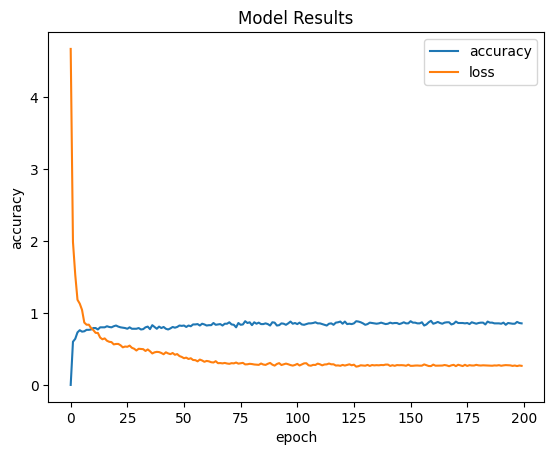

In [690]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Results')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.show()

In [691]:
generator = callback('what is a guitar ? ', model, 1)
output = generator.on_epoch_end(0)

generated text:
what is a guitar ? instrument have ? instrument have ? ? ? ? ? ?



In [544]:
# text_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('text_output').output)
graph_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('graph_output').output)
text = 'what does a guitar have ?'

ValueError: No such layer: graph_output.

In [67]:
generator = callback(text, text_model, 1)
output = generator.on_epoch_end(0)

NameError: name 'text_model' is not defined

In [68]:
generator = callback(text, graph_model, 1)
output = generator.on_epoch_end(0)

generated text:
what does a guitar have ? strings . have        



In [546]:
start_tokens, tokens_generated, num_tokens_generated, raw_output = generator.generate_token([_ for _ in generator.start_tokens], [])
index = len(generator.start_tokens) - 1
raw_output[0][index], tf.argmax(raw_output[0][index]), np.max(raw_output[0][index]), vocab[tf.argmax(raw_output[0][index])], tokens_generated, generator.get_text(tokens_generated)

(array([ 8.610388  , -1.6791879 , -3.24541   ,  0.26236695,  2.175409  ,
        -0.8530191 , -1.3326206 , -0.23728509, -0.38876814, -2.6829703 ,
         0.56378245,  9.13348   , -0.485429  , -1.0320439 ,  5.0149264 ,
         4.431537  , -1.1645554 , -1.2282362 , -2.6345642 , -1.9983232 ,
        -1.4956613 , -1.8706957 , -2.51437   , -1.4542766 , -1.4320389 ,
        -1.1317215 , -2.5611098 , -2.000099  , -0.6902141 , -2.0132465 ,
        -2.2481308 , -2.280425  , -1.4077936 , -1.9086982 , -2.40543   ,
        -2.894787  , -1.4746737 , -1.6406    , -1.2379739 , -2.1711526 ,
        -2.5527833 , -1.6700995 , -1.632331  , -0.7351684 , -2.2373908 ,
        -1.2984204 , -1.9633299 ,  0.5533819 , -0.8745256 , -0.67661107,
        -0.25896448, -1.6493924 , -1.1949381 , -1.9469591 , -1.650917  ,
        -1.6628963 , -0.6690476 , -0.87952465, -1.2783971 , -2.6870615 ,
        -0.35044444, -2.4956439 , -0.9483382 , -2.366705  , -1.0432024 ,
        -0.30593485, -0.93249303, -0.60083634, -0.3

In [548]:
for token, val in zip(vocab, raw_output[0][4]):
    print(token,val)

 8.610388
[UNK] -1.6791879
what -3.24541
a 0.26236695
? 2.175409
have -0.8530191
does -1.3326206
. -0.23728509
is -0.38876814
violin -2.6829703
piano 0.56378245
instrument 9.13348
guitar -0.485429
truck -1.0320439
strings 5.0149264
neck 4.431537
car -1.1645554
wheels -1.2282362
vehicle -2.6345642
trunk -1.9983232
pedals -1.4956613
part -1.8706957
keys -2.51437
baggage -1.4542766


### Injection

In [284]:
def generate_embeddings(model, input):
    start_tokens = [word_to_index.get(_, 1) for _ in input.split()]
    print(start_tokens)
    pad_len = maxlen - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
        x = start_tokens[:maxlen]
        sample_index = maxlen - 1
    elif pad_len > 0:
        x = start_tokens + [0] * pad_len
    else:
        x = start_tokens
    x = np.array([x])
    print(sample_index)

    return model.predict(x)

In [285]:
final_output = generate_embeddings(model, 'what does a guitar have ?')
tokens = []
for output in final_output[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

[2, 6, 3, 12, 5, 4]
5


['does', 'a', 'guitar', 'have', '?', 'neck', '', '', '', '']

In [287]:
embedding_model = keras.Model(inputs=[model.input], outputs=[model.get_layer('embedding_layer').output])
transformer_model = keras.models.Sequential([
    keras.layers.Input((10,128)),
    TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='transformer_layer'),
    keras.layers.Dense(vocab_size, name='text_output')
])
original_weights = get_transformer_weights(model, 'transformer_layer', 'text_output')
set_transformer_weights(transformer_model, 'transformer_layer', 'text_output', original_weights)

In [288]:
texts = ['what does a guitar have ?']
dataset = tf_data.Dataset.from_tensor_slices(texts)
dataset = dataset.map(prepare_lm_inputs_labels)
vectors = generate_embeddings(embedding_model, 'what does a guitar have ?')
outputs = transformer_model.predict(vectors)
tokens = []
for output in outputs[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

x Tensor("strided_slice:0", shape=(None, 10), dtype=int64)
y Tensor("strided_slice_1:0", shape=(None, 10), dtype=int64)
[2, 6, 3, 12, 5, 4]
5


['is', 'a', 'guitar', 'have', '?', 'neck', '', '', '', '']

In [319]:
class CustomNodeEmbedding(layers.Layer):
    def __init__(self, node_embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.node_embed_dim = node_embed_dim
        self.dense = layers.Dense(node_embed_dim)

    def call(self, x):
        node_emb = self.dense(x)  # Apply dense layer to each token embedding
        return node_emb

In [388]:
custom_node_embedding_model = keras.models.Sequential([
    keras.layers.Input((graph_embedding_size)),
    CustomNodeEmbedding(embed_dim)
]
)

custom_node_embedding_model.layers[0].set_weights(model.get_layer('node_embedding_layer').get_weights())


node_embedding_model = keras.Model(inputs=[model.input], outputs=[model.get_layer('node_embedding_layer').output])
# set_node_embedding_weights(node_embedding_model, get_node_embedding_weights(model))
node_transformer_model = keras.models.Sequential([
    keras.layers.Input((10,128)),
    TransformerBlock(embed_dim, num_heads, feed_forward_dim, name='node_transformer_layer'),
    keras.layers.Dense(vocab_size, name='graph_output')
])
original_weights = get_transformer_weights(model, 'node_transformer_layer', 'graph_output')
set_transformer_weights(node_transformer_model, 'node_transformer_layer', 'graph_output', original_weights)

In [440]:
embeddings = [final_embeddings[vocab.index(word)] for word in 'what does a guitar have ?'.split(' ')]
for i in range(maxlen - len(embeddings)):
    embeddings.append(final_embeddings[0])

embeddings = np.array(embeddings)
# embeddings[3][0] += 0.1
embeddings[3] = final_embeddings[vocab.index('piano']
embeddings[3][0]

0.9145890235900879

In [441]:
texts = ['what does a piano have ? neck.']
dataset = tf_data.Dataset.from_tensor_slices(texts)
dataset = dataset.map(prepare_lm_inputs_labels)
# vectors = generate_embeddings(node_embedding_model, 'what does a guitar have ?')
vectors = custom_node_embedding_model.predict(embeddings)
vectors = np.expand_dims(vectors, axis=0)
outputs = node_transformer_model.predict(vectors)
tokens = []
for output in outputs[0]:
    tokens.append(vocab[tf.argmax(output)])
tokens

x Tensor("strided_slice:0", shape=(None, 10), dtype=int64)
y Tensor("strided_slice_1:0", shape=(None, 10), dtype=int64)


['is', 'a', 'truck', '.', '', '', '', '', '', '']

In [442]:
for token, val in zip(vocab, outputs[0][5]):
    print(token,val)

 8.288712
[UNK] 0.97452706
what -1.2253331
a -0.7780448
? 2.1183078
have -0.8638337
does -1.9659276
. -0.2755831
is -1.4778473
violin -1.8833617
piano -2.9525533
instrument 6.613864
guitar -1.6347598
truck 0.025299525
strings 5.4872427
neck 4.991041
car -1.252157
wheels -2.1652482
vehicle -0.6221498
trunk -1.6674696
pedals -1.3050263
part -1.7248017
keys -0.9800917
baggage -1.3884528


In [412]:
outputs[0][4][vocab.index('what')]

-1.9307133

In [194]:
final_embeddings[vocab.index('what')],final_embeddings[vocab.index('does')], final_embeddings[vocab.index('a')], final_embeddings[vocab.index('piano')]

(array([-0.07046904,  0.06283123, -0.02485108,  0.09587689,  0.142355  ,
        -0.06232064, -0.00856199]),
 array([-0.01341391,  0.1197396 ,  0.12872545,  0.09337865, -0.01016603,
         0.11014863, -0.12191909]),
 array([-0.08136626,  0.05501175,  0.03980896,  0.09844395,  0.08715851,
         0.13626422,  0.13247739]),
 array([ 0.84344125, -0.02662537, -1.49284065,  0.77122533, -1.93575537,
        -1.42882872,  2.14216161]))